In [1]:
import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import pickle

In [2]:
predata = pd.read_csv('precovid.csv', index_col=False)
postdata = pd.read_csv('postcovid.csv', index_col=False)

# Exploratory Data Analysis (EDA)

In [3]:
## To remove the unwanted columns : predata
minus = ['Unnamed: 1', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 15', 'Run by:  RDL', 'Unnamed: 19', 'Unnamed: 21', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30']
predata.drop(minus, inplace =True, axis =1)

In [4]:
## To remove the unwanted columns : postdata
minus1 = ['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 15', 'Run by:  RDL', 'Unnamed: 19', 'Unnamed: 21', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29']
postdata.drop(minus1, inplace =True, axis =1)

In [5]:
predata.rename(columns={'SW Wales Cancer Centre': 'Date', 'Unnamed: 2': 'Time', 'Unnamed: 5':'Patient Number', 
                    'Unnamed: 8': 'Procedure Code', 'Unnamed: 11': 'Description', 'Unnamed: 14': 'Status', 'Unnamed: 16': 'In/Out Patient', 'Unnamed: 17': 'Protocol Code', 
                    'Unnamed: 20': 'Staff Initials'}, inplace = True)
predata.rename(columns={predata.columns[9]: 'Location'}, inplace = True)

In [6]:
predata = predata.dropna(how='any',axis=0) 

In [7]:
predata

,Date,Time,Patient Number,Procedure Code,Description,Status,In/Out Patient,Protocol Code,Staff Initials,Location
0,2/1/2020,10:57 AM,Patient 1,Image 01,Image Portal x1,1.0,In,C80.9 00,EEC,LC
1,2/1/2020,10:57 AM,Patient 1,Met/Bone1j,Sacrum/5#,1.0,In,C80.9 00,EEC,LC
2,2/1/2020,11:18 AM,Patient 2,Calc,Calc single/parallel,1.0,In,C50.9 01,MR,LC
3,2/1/2020,11:18 AM,Patient 2,Image 01,Image Portal x1,1.0,In,C50.9 01,MR,LC
4,2/1/2020,11:18 AM,Patient 2,Met/Bone5,Spinal Cord Comp/1#,1.0,In,C50.9 01,MR,LC
...,...,...,...,...,...,...,...,...,...,...
980,2/27/2020,4:33 PM,Patient 67,Image 02,Image Portal x2,1.0,Out,C50.9 01,MR,LC
981,2/27/2020,4:43 PM,Patient 26,Breast 6b,Breast Boost/5# Elec,1.0,Out,C50.9 01,MR,LC
982,2/27/2020,4:58 PM,Patient 89,Breast 1l,IMRT Breath Hold 15#,1.0,Out,C50.9 01,DP,LC
983,2/27/2020,5:08 PM,Patient 23,Breast 6b,Breast Boost/5# Elec,1.0,Out,C50.9 01,MR,LC


In [8]:
postdata.rename(columns={'SW Wales Cancer Centre': 'Date', 'Unnamed: 3': 'Time', 'Study Number':'Patient Number', 
                        'Unnamed: 14': 'Status', 'Unnamed: 16': 'In/Out Patient', 'Unnamed: 17': 'Protocol Code', 
                    'Unnamed: 20': 'Staff Initials'}, inplace = True)
postdata.rename(columns={postdata.columns[9]: 'Location'}, inplace = True)

In [9]:
postdata = postdata.dropna(how='any',axis=0) 

In [10]:
postdata

,Date,Time,Patient Number,Procedure Code,Description,Status,In/Out Patient,Protocol Code,Staff Initials,Location
0,2/1/2021,9:06 AM,5.0,Image 02,Image Portal x2,1,Out,C50.9 01,FMS,LN2
1,2/1/2021,9:06 AM,5.0,Breast 1q,IMRT Breath Hold 5#,1,Out,C50.9 01,FMS,LN2
2,2/1/2021,9:38 AM,90.0,IMRT/VMAT,Plan IMRT/VMAT,1,Out,C50.9 01,FMS,LN2
3,2/1/2021,9:41 AM,49.0,IMRT/VMAT,Plan IMRT/VMAT,1,Out,C50.9 01,FMS,LN2
4,2/1/2021,9:45 AM,72.0,Breast 1m,IMRT Breast&SCF 15#,1,Out,C50.9 01,FMS,LN2
...,...,...,...,...,...,...,...,...,...,...
714,2/25/2021,12:20 PM,63.0,Met/Other,Other Mets,1,Out,C34.9 01,JFL,LN2
715,2/25/2021,12:36 PM,79.0,Image 30,Cone Beam,1,Out,C61.9 02,JFL,LN2
716,2/25/2021,12:36 PM,79.0,Urology 2v,VMAT Prostate 20#,1,Out,C61.9 02,JFL,LN2
717,2/25/2021,12:57 PM,80.0,Image 02,Image Portal x2,1,Out,C50.9 01,FMS,LN2


In [11]:
predata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 984
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            985 non-null    object 
 1   Time            985 non-null    object 
 2   Patient Number  985 non-null    object 
 3   Procedure Code  985 non-null    object 
 4   Description     985 non-null    object 
 5   Status          985 non-null    float64
 6   In/Out Patient  985 non-null    object 
 7   Protocol Code   985 non-null    object 
 8   Staff Initials  985 non-null    object 
 9   Location        985 non-null    object 
dtypes: float64(1), object(9)
memory usage: 84.6+ KB


In [12]:
postdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 718
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            718 non-null    object 
 1   Time            718 non-null    object 
 2   Patient Number  718 non-null    float64
 3   Procedure Code  718 non-null    object 
 4   Description     718 non-null    object 
 5   Status          718 non-null    int64  
 6   In/Out Patient  718 non-null    object 
 7   Protocol Code   718 non-null    object 
 8   Staff Initials  718 non-null    object 
 9   Location        718 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 61.7+ KB


# CHART 1 : Count of patients handled by each staff member

Pre Covid Dataset Visualization

In [13]:
pre_staff_patients = predata['Staff Initials'].value_counts()
pre_staff_patients

FMS    352
MR     311
DP     251
VV      19
EEC     12
JFL      8
RET      8
MP       7
SG       4
AB       4
KR       3
RD       3
RB       3
Name: Staff Initials, dtype: int64

In [14]:
pre_staff = pre_staff_patients.index.values
pre_staff_patients = pre_staff_patients.tolist()

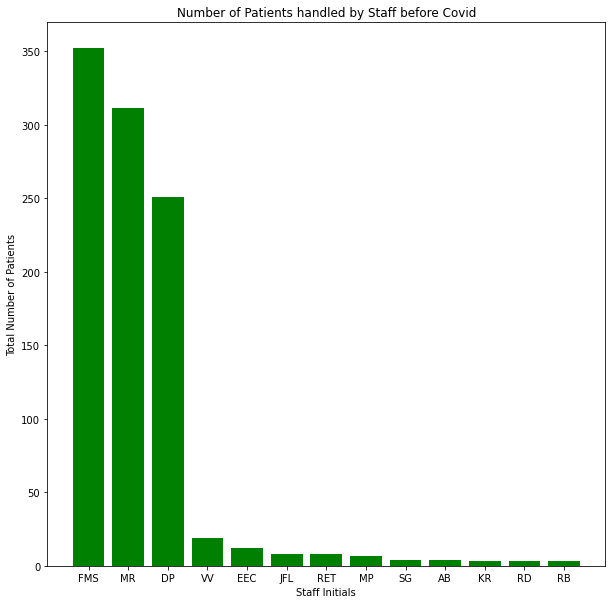

In [15]:
plt.figure(figsize=(10,10))
plt.bar(pre_staff, pre_staff_patients, color = 'green')
plt.title('Number of Patients handled by Staff before Covid')
plt.xlabel('Staff Initials')
plt.ylabel('Total Number of Patients')

## Saving the graph as a png for Dashboard
plt.savefig('prestaffcount.png', dpi=500)

Post Covid Dataset Visualization

In [16]:
post_staff_patients = postdata['Staff Initials'].value_counts()
post_staff = post_staff_patients.index.values
post_staff_patients = post_staff_patients.tolist()

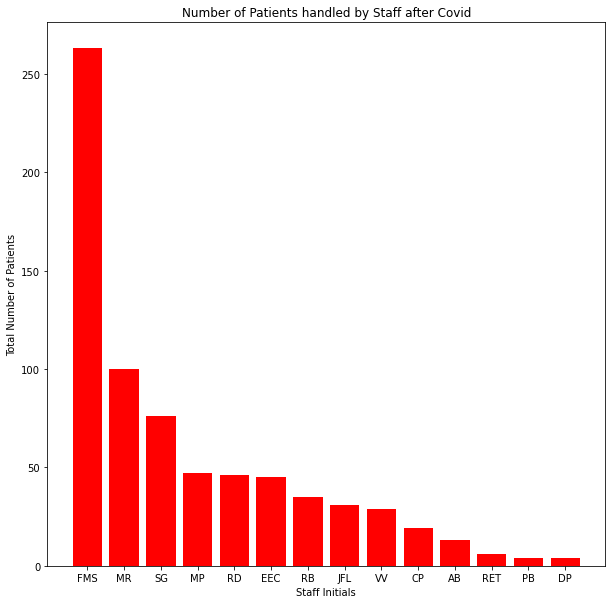

In [17]:
plt.figure(figsize=(10,10))
plt.bar(post_staff, post_staff_patients, color = 'red')
plt.title('Number of Patients handled by Staff after Covid')
plt.xlabel('Staff Initials')
plt.ylabel('Total Number of Patients')

## Saving the graph as a png for Dashboard
plt.savefig('poststaffcount.png', dpi=500)

# Chart 2: Number of Visits till date per Patient

Pre Covid Dataset Visualization

In [18]:
precount = predata['Patient Number'].value_counts()
pre_p = pd.DataFrame(precount.values, precount.index)
pre_p.sort_index(inplace = True)
pre_patient_number = pre_p.index.values
pre_visit = pre_p[0]

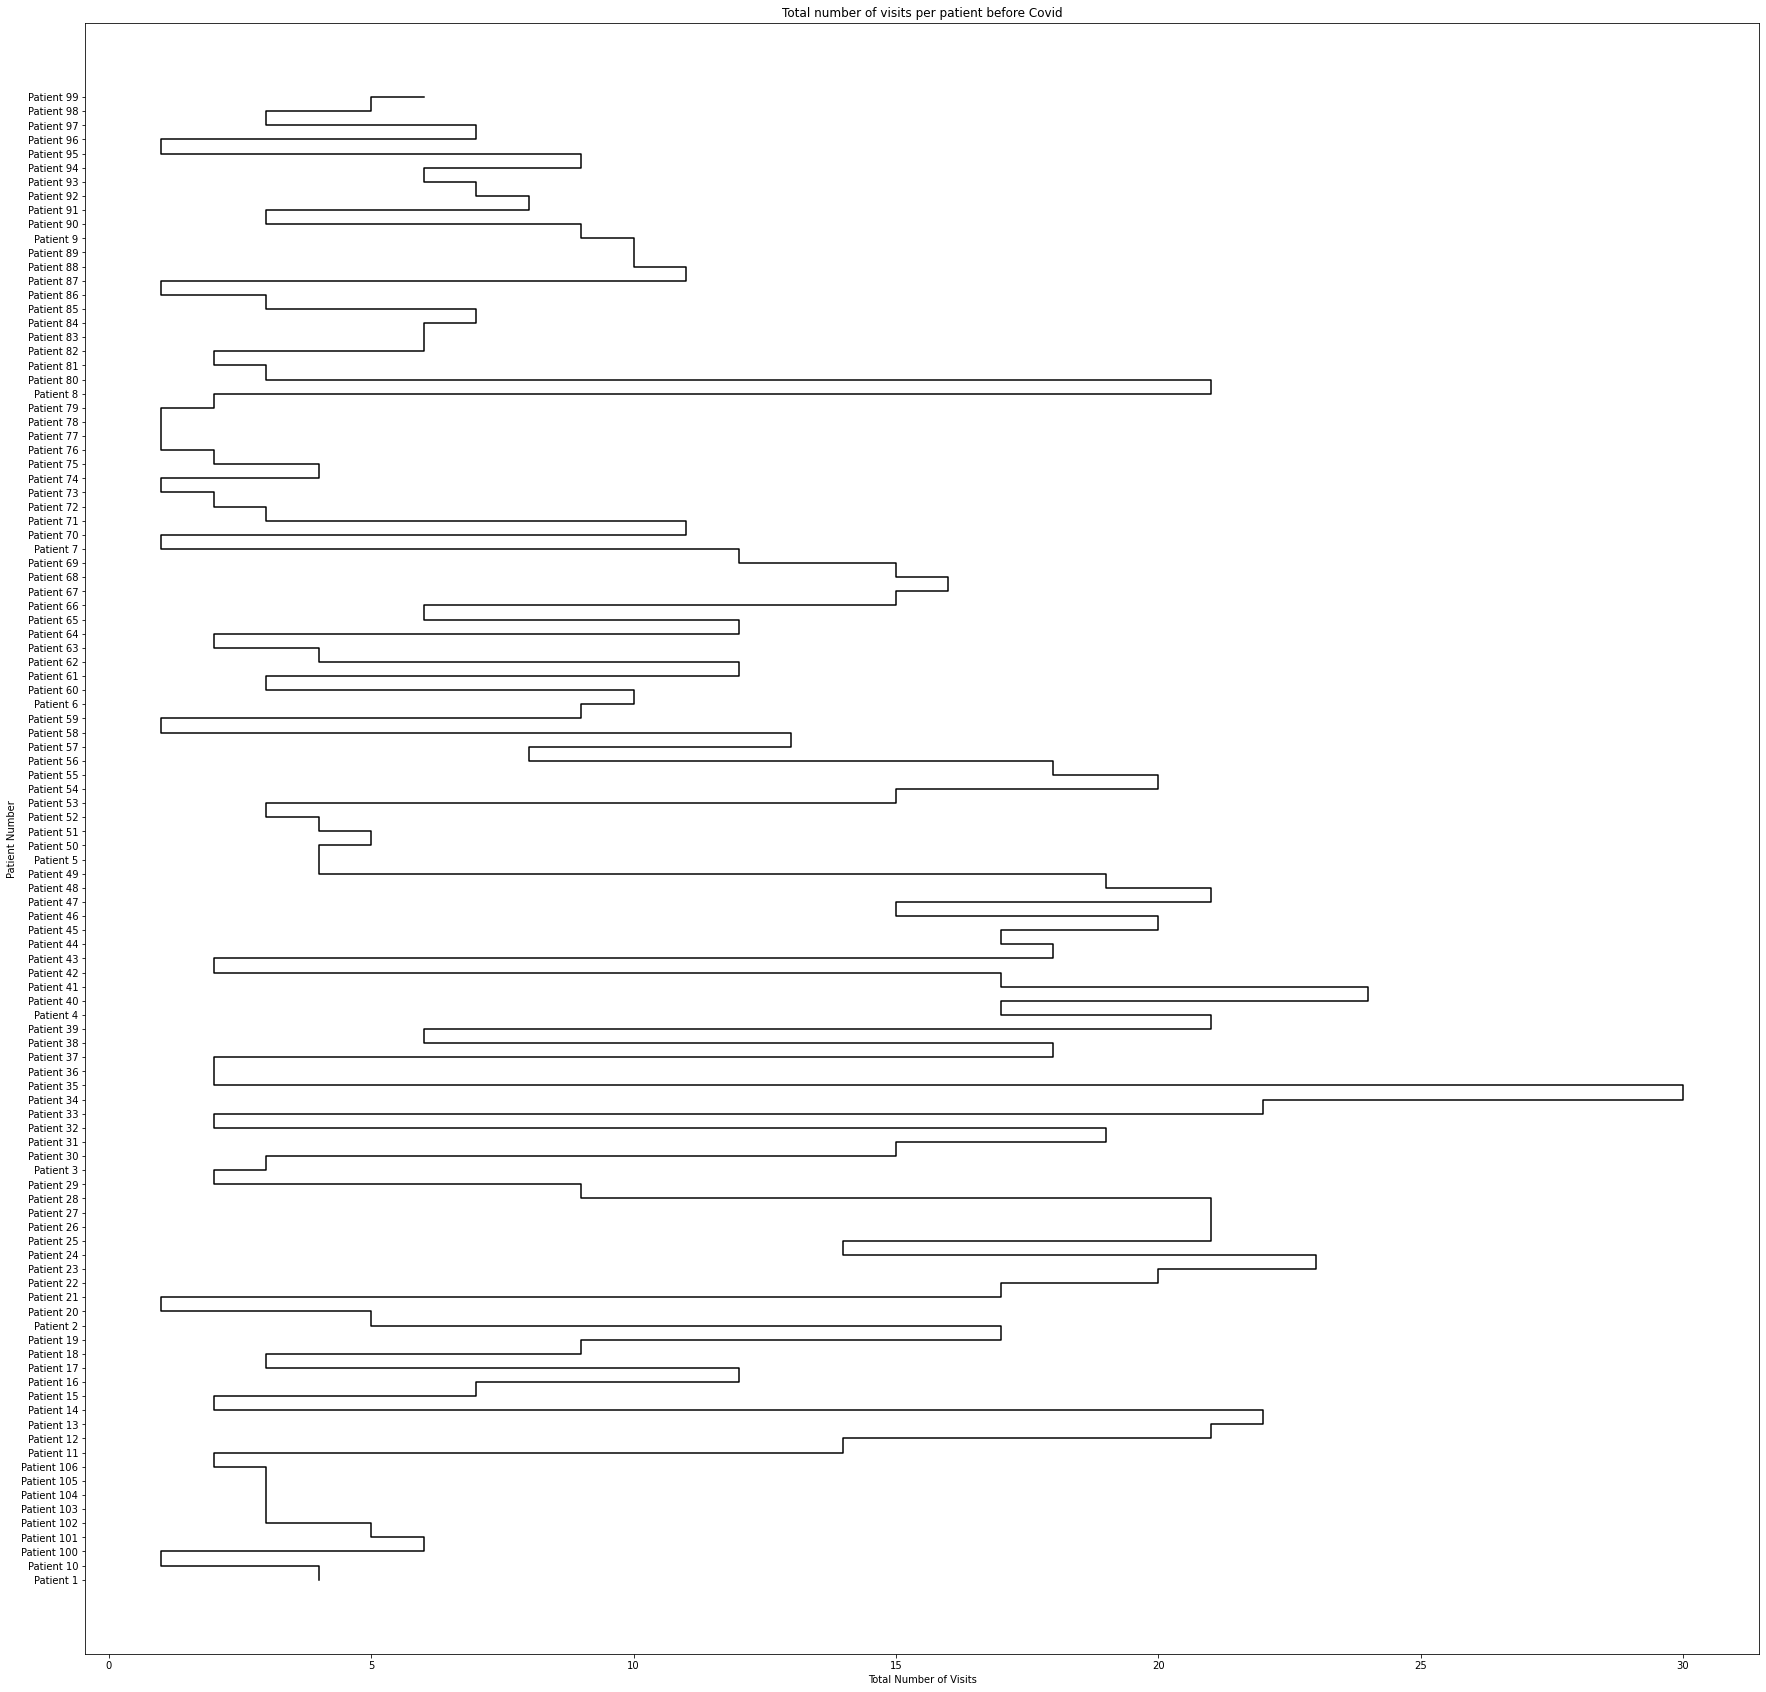

In [19]:
plt.figure(figsize=(30,30))
plt.step(pre_visit, pre_patient_number, color = 'black')
plt.title('Total number of visits per patient before Covid')
plt.xlabel('Total Number of Visits')
plt.ylabel('Patient Number')


plt.savefig("prepatientvisit.png", dpi=700)

Post Covid Dataset Visualization

In [20]:
postcount = postdata['Patient Number'].value_counts()
post_p = pd.DataFrame(postcount.values, postcount.index)
post_p.sort_index(inplace = True)
post_patient_number = post_p.index.values
post_visit = post_p[0]

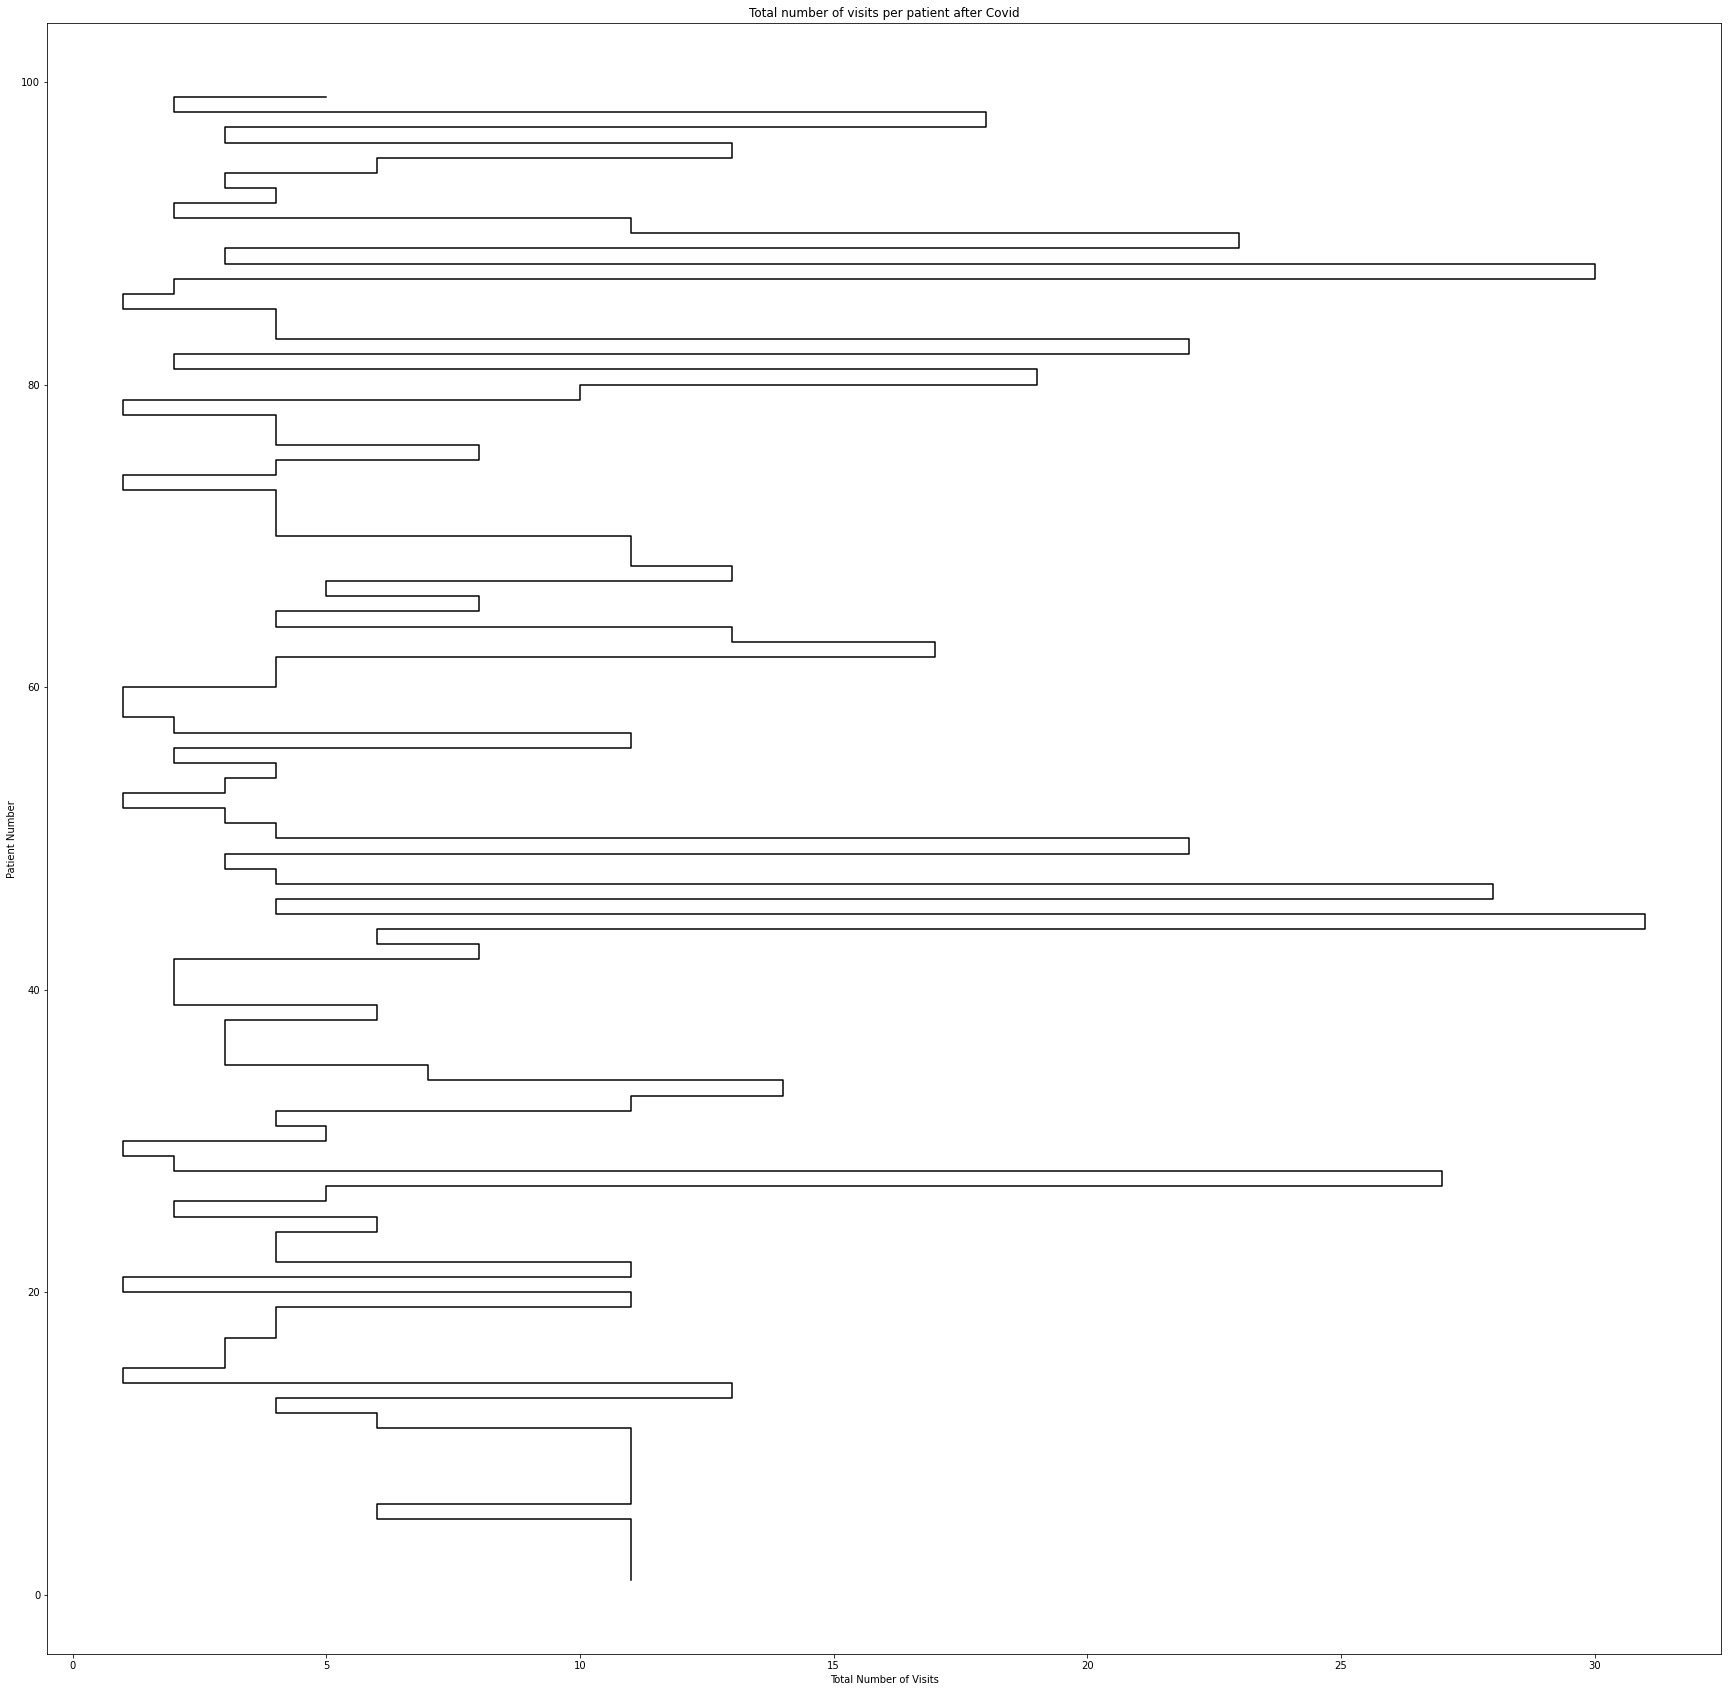

In [21]:
plt.figure(figsize=(30,30))
plt.step(post_visit, post_patient_number, color = 'black')
plt.title('Total number of visits per patient after Covid')
plt.xlabel('Total Number of Visits')
plt.ylabel('Patient Number')

plt.savefig("postpatientvisit.png", dpi=700)

# Chart 3: Number of In/Out Patients per Day


Pre Covid Dataset Visualization

In [22]:
pre_IO_data = predata.groupby(['Date', 'In/Out Patient'], as_index=False).size().pivot('Date', 'In/Out Patient', 'size').replace(np.nan, 0)

In [23]:
pre_dates = pre_IO_data.index.values
pre_dates = pd.to_datetime(pre_dates)

In [24]:
pre_in_values= pre_IO_data['In'].values
pre_out_values= pre_IO_data['Out'].values

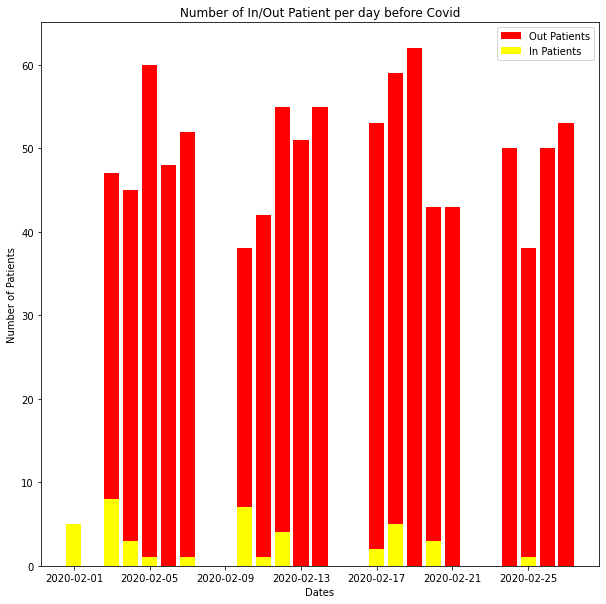

In [25]:
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(pre_dates, pre_out_values, label='Out Patients', color = 'red')
ax.bar(pre_dates, pre_in_values, label='In Patients', color = 'yellow')
ax.set_title('Number of In/Out Patient per day before Covid')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of Patients')
ax.legend()
plt.show()

fig.savefig("preinout.png", dpi=500)

Post Covid dataset Visualization

In [26]:
post_IO_data = postdata.groupby(['Date', 'In/Out Patient'], as_index=False).size().pivot('Date', 'In/Out Patient', 'size').replace(np.nan, 0)

In [27]:
post_dates = post_IO_data.index.values
post_dates = pd.to_datetime(post_dates)

In [28]:
post_in_values= post_IO_data['In'].values
post_out_values= post_IO_data['Out'].values

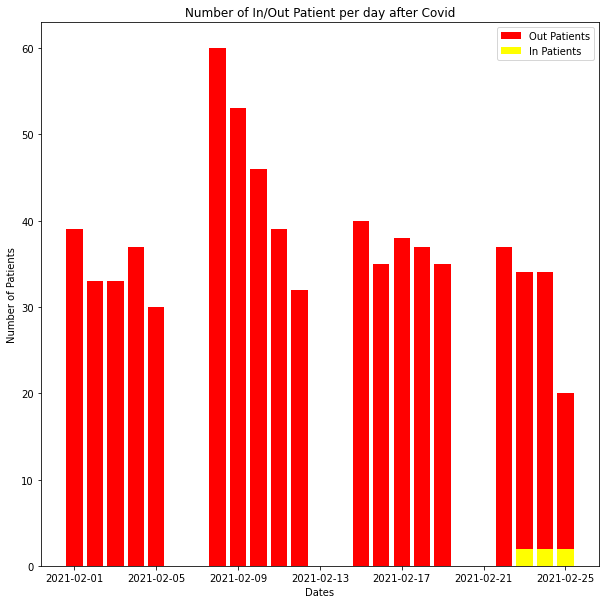

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(post_dates, post_out_values, label='Out Patients', color = 'red')
ax.bar(post_dates, post_in_values, label='In Patients', color = 'yellow')
ax.set_title('Number of In/Out Patient per day after Covid')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of Patients')
ax.legend()
plt.show()

fig.savefig("postinout.png", dpi=500)

# Chart 4: Finding the count of patients per day for the dataset

Pre Covid Data Visualization

In [30]:
predata['Date'] = pd.to_datetime(predata['Date'])

In [31]:
pre_data_patient = pd.DataFrame(predata.groupby(['Date']).sum('Status'))

In [32]:
pre_data_patient

,Status
Date,
2020-02-01,5.0
2020-02-03,55.0
2020-02-04,48.0
2020-02-05,61.0
2020-02-06,48.0
2020-02-07,53.0
2020-02-10,45.0
2020-02-11,43.0
2020-02-12,59.0


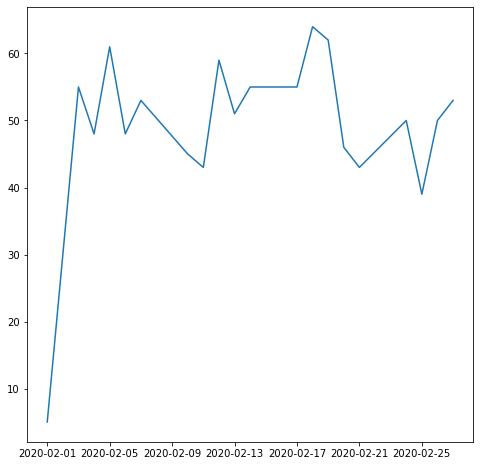

In [33]:
plt.figure(figsize=(8,8))
plt.plot(pre_data_patient)

Post Covid Data Visualization

In [34]:
postdata['Date'] = pd.to_datetime(postdata['Date'])

In [35]:
post_data_patient = pd.DataFrame(postdata.groupby(['Date']).sum('Status'))
post_data_patient

,Patient Number,Status
Date,,
2021-02-01,2532.0,39
2021-02-02,2015.0,33
2021-02-03,1938.0,33
2021-02-04,1935.0,37
2021-02-05,1757.0,30
2021-02-08,2654.0,60
2021-02-09,2394.0,53
2021-02-10,1911.0,46
2021-02-11,1578.0,39


In [36]:
post_data_patient.drop(['Patient Number'], inplace = True, axis = 1)

In [37]:
post_data_patient

,Status
Date,
2021-02-01,39
2021-02-02,33
2021-02-03,33
2021-02-04,37
2021-02-05,30
2021-02-08,60
2021-02-09,53
2021-02-10,46
2021-02-11,39


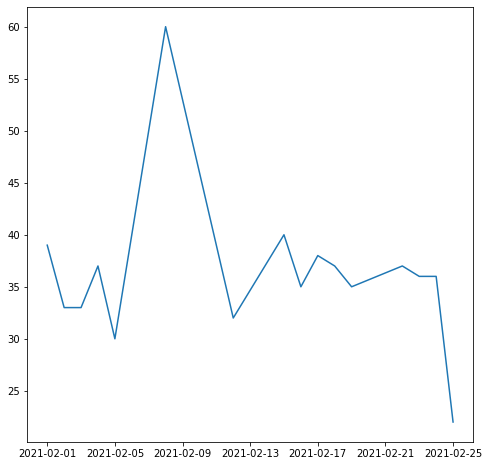

In [38]:
plt.figure(figsize=(8,8))
plt.plot(post_data_patient)

# Classification Models

Frequency Encoding

We will be transforming the column values into numeric values so that it can fit well in the classification models. 
In the following code, we will be classifying whether a patient is In Patient or Out Patient depending on their Protocol Code and Procedure Code. 
Since the In-Patient is very low is postdata dataset, we will be only working with predata dataset

In [39]:
predata_procedurecode = predata['Procedure Code'].value_counts()
predata_procedurecode.count()

34

In [40]:
predata_protocolcode = predata['Protocol Code'].value_counts()
predata_protocolcode.count()

16

In [41]:
fe_predata_procedurecode = predata_procedurecode
fe_predata_protocolcode = predata_protocolcode

In [42]:
# converting the Count of labels into dictionary and saving into variable

fe_predata_procedurecode_dict = fe_predata_procedurecode.to_dict()

In [43]:
fe_predata_protocolcode_dict = fe_predata_protocolcode.to_dict()

In [44]:
# Creating a new dataset with just Procedure Code, Protocol Code and Patient In/Out Status

fe_predata = predata[['Procedure Code', 'Protocol Code', 'In/Out Patient']]

In [45]:
fe_predata.head()

,Procedure Code,Protocol Code,In/Out Patient
0,Image 01,C80.9 00,In
1,Met/Bone1j,C80.9 00,In
2,Calc,C50.9 01,In
3,Image 01,C50.9 01,In
4,Met/Bone5,C50.9 01,In


In [46]:
# Replacing the label with the count in dataset
fe_predata['Procedure Code'] = fe_predata['Procedure Code'].map(fe_predata_procedurecode_dict)

In [47]:
fe_predata['Protocol Code'] = fe_predata['Protocol Code'].map(fe_predata_protocolcode_dict)

In [48]:
enc = OrdinalEncoder()
fe_predata['Out Patient'] = enc.fit_transform(fe_predata[['In/Out Patient']])
fe_predata

,Procedure Code,Protocol Code,In/Out Patient,Out Patient
0,23,10,In,0.0
1,2,10,In,0.0
2,21,886,In,0.0
3,23,886,In,0.0
4,1,886,In,0.0
...,...,...,...,...
980,261,886,Out,1.0
981,22,886,Out,1.0
982,195,886,Out,1.0
983,22,886,Out,1.0


In [49]:
fe_predata.drop(['In/Out Patient'], inplace = True, axis = 1)

In [50]:
fe_predata.head()

,Procedure Code,Protocol Code,Out Patient
0,23,10,0.0
1,2,10,0.0
2,21,886,0.0
3,23,886,0.0
4,1,886,0.0


In [51]:
fe_predata.corr()

,Procedure Code,Protocol Code,Out Patient
Procedure Code,1.000000,0.386153,0.257227
Protocol Code,0.386153,1.000000,0.269618
Out Patient,0.257227,0.269618,1.000000


# Support Vector Machine Classifier along with Grid Search

In [52]:
X = fe_predata.iloc[:, [0,1]].values
y = fe_predata.iloc[:, 2].values

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [56]:
pred = classifier.predict(X_test)

In [57]:
accuracy = accuracy_score(y_test, pred)
accuracy

0.9390862944162437

In [58]:
params = [{'C': [10, 50, 100, 300],'kernel': ['linear']},
          {'C': [10, 50, 100, 300], 'kernel': ['sigmoid'], 'gamma': [0.05, 0.10, 0.15, 0.20, 0.25]},
          {'C': [10, 50, 100, 300], 'kernel': ['poly'], 'gamma': [0.05, 0.10, 0.15, 0.20, 0.25]}]

grid_search = GridSearchCV(estimator = classifier, param_grid = params, scoring = 'accuracy', cv = 10, n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)

In [59]:
a = grid_search.best_score_
a

0.9632099967543006

In [60]:
grid_search.best_params_

{'C': 10, 'kernel': 'linear'}

In [61]:
classifier = SVC(C = 20, kernel = 'linear', probability = True)
classifier.fit(X_train, y_train)

SVC(C=20, kernel='linear', probability=True)

In [62]:
pred = classifier.predict(X_test)

In [63]:
metrics.f1_score(y_test, pred, average = 'weighted', labels = np.unique(pred))

0.9685863874345549

# Naive Bayes Classification with Gaussian Model


We will be implementing the Naive Bayes Classifier with Guassian Model. 
We will be taking fe_predata dataset as above. X and y for training and testing remains the same.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [65]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [66]:
model = GaussianNB()

In [67]:
model.fit(X_train, y_train)

GaussianNB()

In [68]:
model.score(X_test, y_test)

0.9222972972972973

In [69]:
cross_val_score(GaussianNB(), X_train, y_train, cv= 10)

array([0.97101449, 0.94202899, 0.95652174, 0.88405797, 0.91304348,
       0.91304348, 0.91304348, 0.88405797, 0.88405797, 0.97058824])

In [70]:
recall_score(y_test, model.predict(X_test))

0.95

In [71]:
precision_score(y_test, model.predict(X_test))

0.9672727272727273

In [72]:
f1_score(y_test, model.predict(X_test))

0.9585585585585585

In [73]:
nb_pred = model.predict(X_test)

In [74]:
nb_conf_matrix = confusion_matrix( nb_pred, y_test)

In [75]:
nb_conf_matrix

array([[  7,  14],
       [  9, 266]], dtype=int64)

In [76]:
fe_predata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 984
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Procedure Code  985 non-null    int64  
 1   Protocol Code   985 non-null    int64  
 2   Out Patient     985 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 30.8 KB


In [77]:
# Predicting whether the patient is In/Out-- In Patient yields output 0. and Out Patient yields output 1.
model.predict([[22, 886]])

array([0.])

In [78]:
## ROC Curve

In [79]:
r_prob= [ 0 for _ in range (len(y_test))]
svm_prob = classifier.predict_proba(X_test)
nb_prob = model.predict_proba(X_test)

In [80]:
svm_prob = svm_prob[:,1]
nb_prob = nb_prob[:,1]

In [81]:
# Calculate AUROC

svm_auc = roc_auc_score(y_test, svm_prob)
nb_auc = roc_auc_score(y_test, nb_prob)

In [82]:
# Predicting Test Results

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)

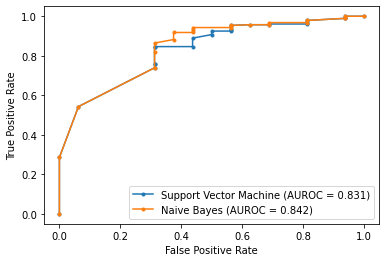

In [83]:
# Plotting ROC Curve

plt.plot(svm_fpr, svm_tpr, marker = '.', label = 'Support Vector Machine (AUROC = %0.3f)' % svm_auc)
plt.plot(nb_fpr, nb_tpr, marker = '.', label = 'Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.xlabel ("False Positive Rate")
plt.ylabel ("True Positive Rate")
plt.legend()

# Time Forecasting ARIMA Model

We will now be implementing the ARIMA Model on predata as well as postdata dataset. This is a time forecasting model, which will help us predict the number of footfalls/ patients visting the hospital every day

ARIMA Model on Pre Covid Dataset

In [84]:
predata_patient = pd.read_csv('precovid.csv', index_col=False)

In [85]:
## To remove the unwanted columns : predata
minus = ['Unnamed: 1', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 15', 'Run by:  RDL', 'Unnamed: 19', 'Unnamed: 21', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30']
predata_patient.drop(minus, inplace =True, axis =1)

In [86]:
predata_patient.rename(columns={'SW Wales Cancer Centre': 'Date', 'Unnamed: 2': 'Time', 'Unnamed: 5':'Patient Number', 
                    'Unnamed: 8': 'Procedure Code', 'Unnamed: 11': 'Description', 'Unnamed: 14': 'Status', 'Unnamed: 16': 'In/Out Patient', 'Unnamed: 17': 'Protocol Code', 
                    'Unnamed: 20': 'Staff Initials'}, inplace = True)
predata_patient.rename(columns={predata_patient.columns[9]: 'Location'}, inplace = True)

In [87]:
predata_patient = predata_patient.dropna(how='any',axis=0) 

In [88]:
predata_patient.drop(['Patient Number'], inplace = True, axis = 1 )

In [89]:
predata_patient['Date'] = pd.to_datetime(predata_patient['Date'])

In [90]:
predata_patient = pd.DataFrame(predata_patient.groupby(['Date']).sum('Status'))

In [91]:
predata_patient.head()

,Status
Date,
2020-02-01,5.0
2020-02-03,55.0
2020-02-04,48.0
2020-02-05,61.0
2020-02-06,48.0


In [92]:
predata_patient.shape

(20, 1)

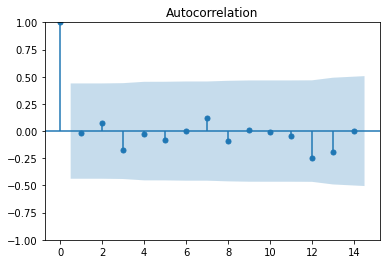

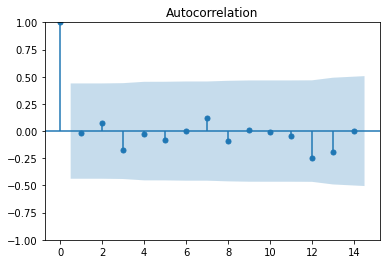

In [93]:
# Plotting ACF to calculate Moving Average

plot_acf(predata_patient)

In [94]:
stepwise_fit_pre = auto_arima(predata_patient['Status'], trace = True, suppress_warnings = True, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=171.926, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=215.802, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=169.205, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=168.330, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=170.069, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=169.929, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=168.872, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=171.928, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=164.089, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=162.396, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=160.414, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=162.402, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=163.905, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Tota

In [95]:
stepwise_fit_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                        SARIMAX   Log Likelihood                 -78.207
Date:                Wed, 04 Jan 2023   AIC                            160.414
Time:                        13:54:13   BIC                            162.406
Sample:                             0   HQIC                           160.803
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     49.2500      4.374     11.260      0.000      40.677      57.823
sigma2       145.8875     36.700      3.975      0.000      73.958     217.817
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                50.06
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -2.26
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
pre_train = predata_patient.iloc[: 14]
pre_test = predata_patient.iloc[14 :]

In [97]:
pre_test.shape

(6, 1)

In [98]:
# Tried with various parameters and selected the best one (5,1,2) (4,1,5) (6,1,5) (3,1,1: very good)
pre_model = sm.tsa.arima.ARIMA(pre_train, order = (3,1,1))
pre_model = pre_model.fit()

In [99]:
pre_forecast = pre_model.predict(n_periods = 6)

In [100]:
pre_start = len(pre_train)
pre_end = len(pre_train)+ len(pre_test) - 1
pre_pred = pre_model.predict(start= pre_start, end = pre_end, typ= 'levels')
pre_pred.index = predata_patient.index[pre_start:pre_end+1]
pre_pred

Date
2020-02-20    63.932150
2020-02-21    59.732827
2020-02-24    60.992148
2020-02-25    58.678714
2020-02-26    60.670223
2020-02-27    59.406103
Name: predicted_mean, dtype: float64

In [101]:
pre_test

,Status
Date,
2020-02-20,46.0
2020-02-21,43.0
2020-02-24,50.0
2020-02-25,39.0
2020-02-26,50.0
2020-02-27,53.0


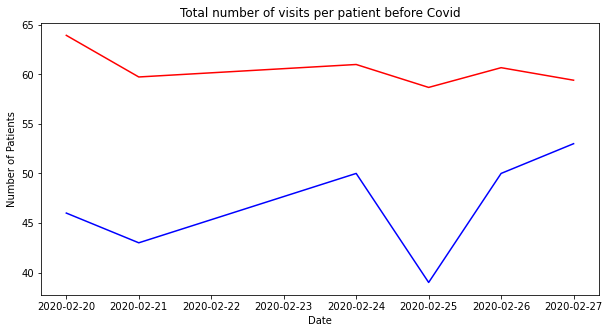

In [102]:
plt.figure(figsize=(10,5))
plt.plot(pre_pred, color = 'red')
plt.plot(pre_test, color = 'blue')
plt.title('Total number of visits per patient before Covid')
plt.xlabel('Date')
plt.ylabel('Number of Patients')

plt.savefig("prearima.png", dpi=700)

In [103]:
np.sqrt(mean_squared_error(pre_test, pre_pred))

14.517348335549036

In [104]:
pre_test.mean()

Status    46.833333
dtype: float64

In [105]:
mean_absolute_percentage_error(pre_test, pre_pred)

0.3062774265037833

ARIMA Model on Post Covid Dataset

In [106]:
postdata_patient = pd.read_csv('postcovid.csv', index_col=False)

In [107]:
## To remove the unwanted columns : postdata
minus2 = ['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 15', 'Run by:  RDL', 'Unnamed: 19', 'Unnamed: 21', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29']
postdata_patient.drop(minus2, inplace =True, axis =1)

In [108]:
postdata_patient.rename(columns={'SW Wales Cancer Centre': 'Date', 'Unnamed: 3': 'Time', 'Study Number':'Patient Number', 
                        'Unnamed: 14': 'Status', 'Unnamed: 16': 'In/Out Patient', 'Unnamed: 17': 'Protocol Code', 
                    'Unnamed: 20': 'Staff Initials'}, inplace = True)
postdata_patient.rename(columns={postdata_patient.columns[9]: 'Location'}, inplace = True)

In [109]:
postdata_patient = postdata_patient.dropna(how='any',axis=0) 

In [110]:
postdata_patient.drop(['Patient Number'], inplace = True, axis = 1 )

In [111]:
postdata_patient['Date'] = pd.to_datetime(postdata_patient['Date'])

In [112]:
postdata_patient = pd.DataFrame(postdata_patient.groupby(['Date']).sum('Status'))

In [113]:
postdata_patient.head()

,Status
Date,
2021-02-01,39
2021-02-02,33
2021-02-03,33
2021-02-04,37
2021-02-05,30


In [114]:
postdata_patient.shape

(19, 1)

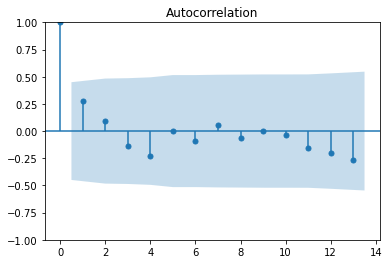

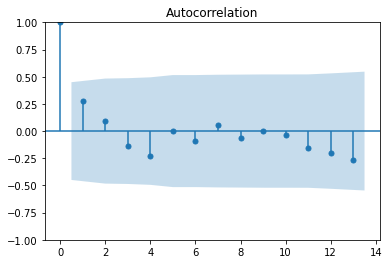

In [115]:
# Plotting ACF to calculate Moving Average

plot_acf(postdata_patient)

In [116]:
stepwise_fit = auto_arima(postdata_patient['Status'], trace = True, suppress_warnings = True, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=147.616, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.768, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=144.237, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=144.734, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=144.301, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=145.242, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=137.048, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=136.894, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=137.340, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=139.048, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.853 seconds


In [117]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 -66.447
Date:                Wed, 04 Jan 2023   AIC                            136.894
Time:                        13:54:39   BIC                            138.783
Sample:                    02-01-2021   HQIC                           137.214
                         - 02-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     37.7895      2.178     17.351      0.000      33.521      42.058
sigma2        63.8504     17.922      3.563      0.000      28.724      98.977
===================================================================================
Ljung-Box (L1) (Q):                   1.71   Jarque-Bera (JB):                 5.97
Prob(Q):                              0.19   Prob(JB):                         0.05
Heteroskedasticity (H):               0.44   Skew:                             1.05
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
post_train = postdata_patient.iloc[: 13]
post_test = postdata_patient.iloc[13 :]

In [119]:
# Tried with various parameters and selected the best one (4,0,0) (4, 0,6) (5,0,5) (5,0,7) (5,1,7) (5,1,5) (4,1,0 : very good)
post_model = sm.tsa.arima.ARIMA(post_train, order = (4,1,0))
post_model = post_model.fit()
post_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Status   No. Observations:                   13
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 -43.156
Date:                Wed, 04 Jan 2023   AIC                             96.312
Time:                        13:54:40   BIC                             98.736
Sample:                    02-01-2021   HQIC                            95.414
                         - 02-17-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4129      0.501     -0.823      0.410      -1.396       0.570
ar.L2         -0.1754      0.612     -0.286      0.775      -1.376       1.025
ar.L3         -0.2488      0.420     -0.593      0.553      -1.071       0.574
ar.L4         -0.3965      1.051     -0.377      0.706      -2.456       1.663
sigma2        72.5315     55.823      1.299      0.194     -36.880     181.943
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.50
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             2.13
Prob(H) (two-sided):                  0.89   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
post_test.shape

(6, 1)

In [121]:
post_forecast = post_model.predict(n_periods = 6)

In [122]:
post_start = len(post_train)
post_end = len(post_train)+ len(post_test) - 1
post_pred = post_model.predict(start= post_start, end = post_end, typ= 'levels')
post_pred.index = postdata_patient.index[post_start:post_end+1]
post_pred

Date
2021-02-18    38.423409
2021-02-19    35.794499
2021-02-22    38.041736
2021-02-23    36.280121
2021-02-24    37.099497
2021-02-25    37.553395
Name: predicted_mean, dtype: float64

In [123]:
post_test

,Status
Date,
2021-02-18,37
2021-02-19,35
2021-02-22,37
2021-02-23,36
2021-02-24,36
2021-02-25,22


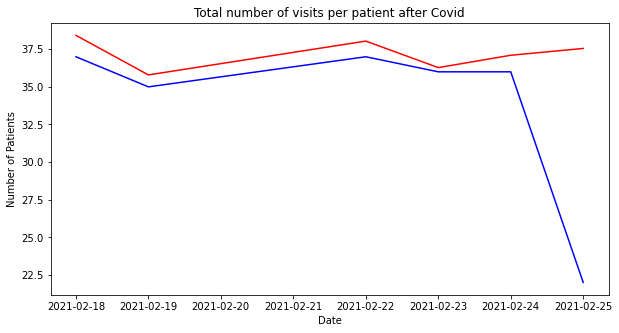

In [124]:
plt.figure(figsize=(10,5))
plt.plot(post_pred, color = 'red')
plt.plot(post_test, color = 'blue')
plt.title('Total number of visits per patient after Covid')
plt.xlabel('Date')
plt.ylabel('Number of Patients')

plt.savefig("postarima.png", dpi=700)

In [125]:
np.sqrt(mean_squared_error(post_test, post_pred))

6.415319971155021

In [126]:
post_test.mean()

Status    33.833333
dtype: float64

In [127]:
mean_absolute_percentage_error(post_test, post_pred)

0.13910344948621203

# Predicting number of Patients for Future Date

Below we will be predicting the number of patients visiting the hospital for future.
Here we will be applying the model to post covid data

In [128]:
# Predicting Future Dates

model_full= sm.tsa.arima.ARIMA(postdata_patient, order = (4,1,0))
model_full = model_full.fit()

In [129]:
postdata_patient.tail()

,Status
Date,
2021-02-19,35
2021-02-22,37
2021-02-23,36
2021-02-24,36
2021-02-25,22


In [130]:
future_dates = pd.date_range(start = '2021-02-25', end = '2021-03-04')
future_pred = model_full.predict(start = len(postdata_patient), end = len(postdata_patient)+7, typ= 'levels').rename('Number of Patients Prediction')
future_pred.index = future_dates
print(future_pred)

2021-02-25    27.315567
2021-02-26    27.886659
2021-02-27    30.561340
2021-02-28    33.384999
2021-03-01    29.514688
2021-03-02    29.689416
2021-03-03    28.459426
2021-03-04    28.891353
Freq: D, Name: Number of Patients Prediction, dtype: float64


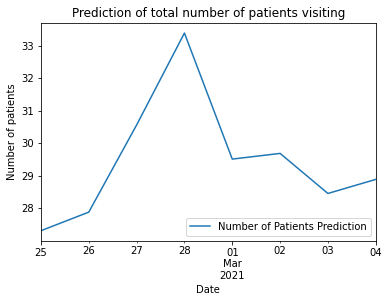

In [131]:
future_pred.plot(legend = True)
plt.title('Prediction of total number of patients visiting')
plt.xlabel('Date')
plt.ylabel('Number of patients')

plt.savefig("future_pred.png", dpi=700)

In [132]:
future_pred[('2021-03-03')]

28.45942608522868